# Proyek Klasifikasi Gambar: [Grape Disease Dataset]
- **Nama:** [Rasyid Alfiansyah]
- **Email:** [rasyidalfiansyh@gmail.com]
- **ID Dicoding:** [rasyidalfiansyh]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library Machine Learning dan Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Library Pengolahan Data dan File
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import cv2
import albumentations as A

# Library Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Library Lain-Lain
import random
import os
import time
import json

# Kaggle
!pip install kaggle

## Inisisialisasi Konfigurasi Pelatihan

In [2]:
class cfg:
    IMAGE_SIZE = 224
    # Data Augmentasi
    BRIGHTNESS = (0.64, 1.37)
    CONTRAST = (0.64, 1.37)
    # Pelatihan Model
    AUGMENTED = True
    DROPOUT = 0.5
    BATCH_SIZE = 8
    EPOCHS = 50
    LEARNING_RATE = 0.0001

## Setting Kaggle API dan Download Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Skripsi/Kaggle_API_Credential/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download rasyidalfiansyah/dataset-grape-disease
! unzip /content/dataset-grape-disease.zip

## Data Preparation

### Data Loading

In [4]:
# Direktori Data
data_directories = [
    '/content/dataset grape disease/Black Rot',
    '/content/dataset grape disease/ESCA',
    '/content/dataset grape disease/Healthy',
    '/content/dataset grape disease/Leaf Blight',
]

all_paths = []
all_labels = []

# Melakukan iterasi melalui setiap direktori
for data_dir in data_directories:
    if not os.path.exists(data_dir):  # Skip jika direktori tidak ada
        print(f"Directory {data_dir} does not exist. Skipping.")
        continue

    # Mengambil semua file dalam direktori
    for image in os.listdir(data_dir):
        # Memastikan file adalah citra
        if image.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_paths.append(os.path.join(data_dir, image))
            # Menambahkan label dari nama folder
            label = os.path.basename(os.path.normpath(data_dir))
            all_labels.append(label)

# Mengacak Data
all_paths, all_labels = shuffle(all_paths, all_labels)

# Menampilkan sebagai DataFrame
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path': all_paths, 'label': all_labels})

print(df)

                                                                                                                 path  \
0              /content/dataset grape disease/Healthy/daf0e2e3-1d2b-4fcf-9dba-1ffa7605766e___Mt.N.V_HL 6210_90deg.JPG   
1                  /content/dataset grape disease/Black Rot/21008a79-e393-498c-b9f8-7c579b911b3e___FAM_B.Rot 0661.JPG   
2                  /content/dataset grape disease/Black Rot/d045079f-ca24-4e40-b203-7c70608c9d02___FAM_B.Rot 0665.JPG   
3                      /content/dataset grape disease/ESCA/2850cff3-e262-49b1-af09-051e76e19fa8___FAM_B.Msls 1336.JPG   
4           /content/dataset grape disease/Black Rot/7b13e721-b94a-46f8-a7dd-7906b3aaf8fa___FAM_B.Rot 0529_flipLR.JPG   
...                                                                                                               ...   
9022            /content/dataset grape disease/ESCA/33ff42ab-8ff7-46b6-baa2-7b7b6ae799af___FAM_B.Msls 3965_flipLR.JPG   
9023          /content/dataset g

### Membuat Fungsi Augmentasi dan Membaca Citra

In [5]:
def augment_image_albumentations(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(1 - cfg.BRIGHTNESS[1], cfg.BRIGHTNESS[1] - 1),
                                 contrast_limit=(1 - cfg.CONTRAST[1], cfg.CONTRAST[1] - 1),
                                 p=1.0),
    ])
    augmented = transform(image=np.array(image))
    return Image.fromarray(augmented['image'])

In [6]:
# Fungsi Untuk Membuka dan Memproses Gambar
def open_images(paths, augment=True):
    images = []
    for path in paths:
        image = load_img(path, target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
        if augment:
            image = augment_image_albumentations(image)
        image = np.array(image)
        image = image / image.max()
        images.append(image)
    return np.array(images)

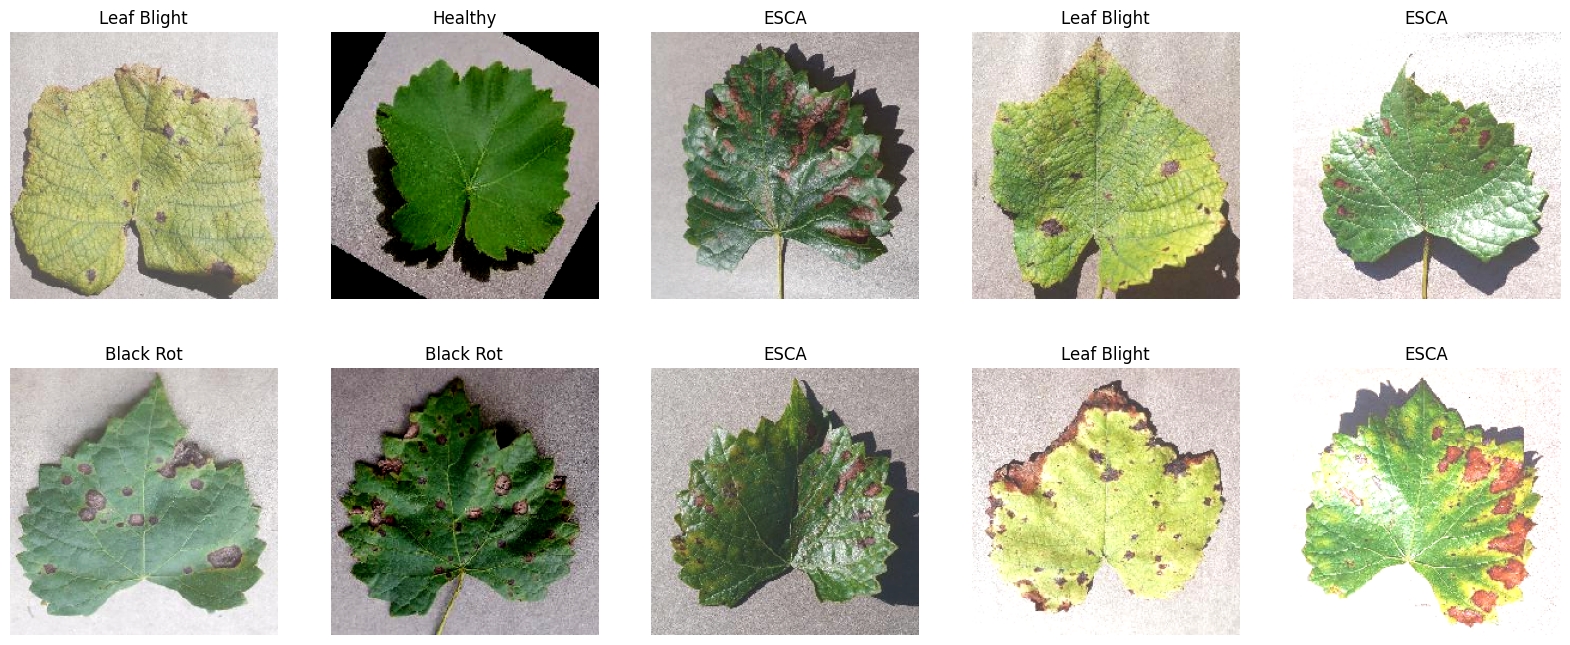

In [7]:
# Visualisasi Beberapa Citra dengan Augmentasi
k = random.randint(0, 5000)
image_paths = list(df.path[k:k + 10])
labels = list(df.label[k:k + 10])
images = open_images(image_paths, augment=True)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))
for i in range(0, 10):
    fig.add_subplot(2, 5, i + 1)
    plt .imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

### Setting Label Encoder-Decoder

In [8]:
# Daftar Label dan Pengkodeannya
LABELS = ['Healthy', 'Black Rot', 'ESCA', 'Leaf Blight']
label_encoder = {'Healthy': 0, 'Black Rot': 1, 'ESCA': 2, 'Leaf Blight': 3}
label_decoder = {0: 'Healthy', 1: 'Black Rot', 2: 'ESCA', 3: 'Leaf Blight'}

### Data Preprocessing

#### Split Dataset

In [9]:
# Menentukan Persentase Pembagian Data
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Memastikan total persentase sesuai dengan 100%
assert train_split + val_split + test_split == 1.0, "Total split harus 1.0"

df_shuffled = df.sample(frac=1, random_state=42)
train_end = int(train_split * len(df_shuffled))
val_end = train_end + int(val_split * len(df_shuffled))

df_train = df_shuffled[:train_end]
df_val = df_shuffled[train_end:val_end]
df_test = df_shuffled[val_end:]

print(f"Train set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")

Train set: 7221 samples
Validation set: 902 samples
Test set: 904 samples


#### Data Generator

In [10]:
# Generator data untuk train, val, dan test
def data_generator(df, batch_size=cfg.BATCH_SIZE, augment=False, epochs=cfg.EPOCHS):
    for e in range(epochs):
        for x in range(0, len(df), batch_size):
            image_paths = df.path[x:x + batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x + batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

# Generator masing-masing set
train_data_generator = data_generator(df_train, batch_size=cfg.BATCH_SIZE, augment=cfg.AUGMENTED)
val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE)
test_data_generator = data_generator(df_test, batch_size=cfg.BATCH_SIZE)

train_steps = int(len(df_train) / cfg.BATCH_SIZE)
val_steps = int(len(df_val) / cfg.BATCH_SIZE)
test_steps = int(len(df_test) / cfg.BATCH_SIZE)

#### Visualisasi Pembagian Data

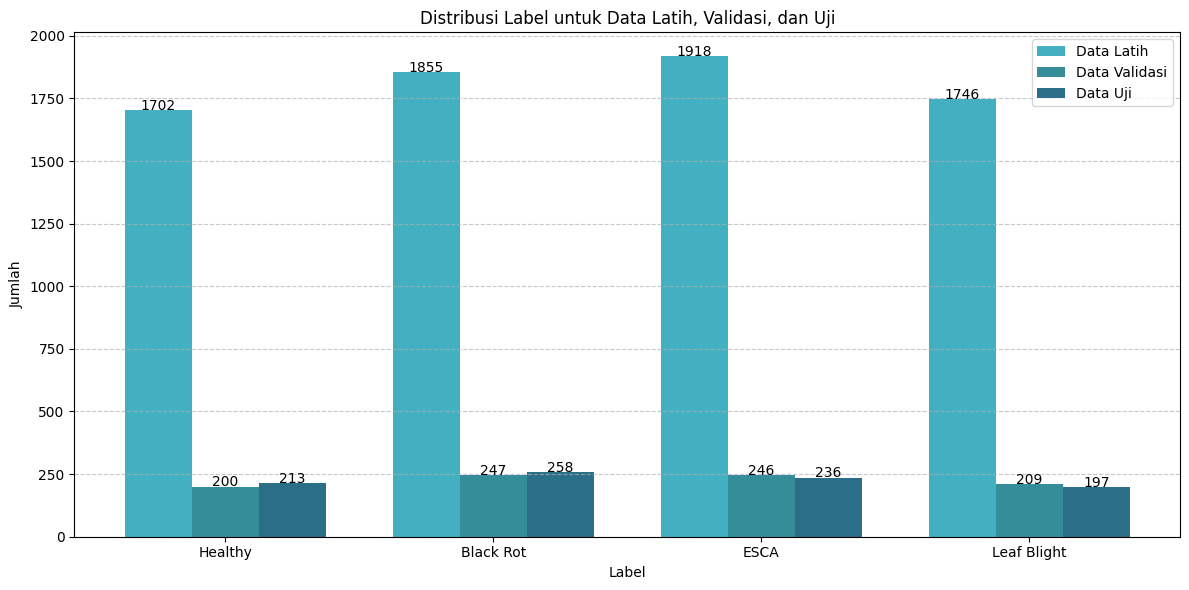

In [11]:
# Distribusi label pada setiap subset
train_counts = df_train['label'].value_counts()
val_counts = df_val['label'].value_counts()
test_counts = df_test['label'].value_counts()

# Visualisasi distribusi
plt.figure(figsize=(12, 6))

# Plot untuk setiap subset
x = np.arange(len(LABELS))
width = 0.25

plt.bar(x - width, train_counts.reindex(LABELS, fill_value=0), width, label='Data Latih', color='#43b0c1')
plt.bar(x, val_counts.reindex(LABELS, fill_value=0), width, label='Data Validasi', color='#368d9a')
plt.bar(x + width, test_counts.reindex(LABELS, fill_value=0), width, label='Data Uji', color='#2a6e88')

for i, v in enumerate(train_counts.reindex(LABELS, fill_value=0)):
    plt.text(i - width, v + 1, str(v), color='black', ha='center')

for i, v in enumerate(val_counts.reindex(LABELS, fill_value=0)):
    plt.text(i, v + 1, str(v), color='black', ha='center')

for i, v in enumerate(test_counts.reindex(LABELS, fill_value=0)):
    plt.text(i + width, v + 1, str(v), color='black', ha='center')

plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Label untuk Data Latih, Validasi, dan Uji')
plt.xticks(x, LABELS)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Modelling

### Membuat Model

In [12]:
# Model CNN Sequential
model = models.Sequential([
    layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3)),  # Input layer
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(cfg.DROPOUT),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')  # Output layer dengan 4 kelas
], name='lightweight_cnn')

# Print model summary
model.summary()

Model: "lightweight_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,605,156 (13.75 MB)

 Trainable params: 3,605,156 (13.75 MB)

 Non-trainable params: 0 (0.00 B)

### Kompilasi Model

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Mengatur Bobot Kelas

In [14]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{2: 0.26561418086137656,
 1: 0.25688962747541894,
 3: 0.24179476526796842,
 0: 0.2357014263952361}

### Fungsi Callback

In [15]:
# Callback untuk menyimpan history training ke file JSON
class SaveHistoryCallback(Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path

    def on_train_end(self, logs=None):
        with open(self.file_path, 'w') as f:
            json.dump(self.model.history.history, f)

# Callback untuk menghitung waktu pelatihan
class TrainingTimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"Total training time: {elapsed_time:.2f} seconds")

# Callback untuk memplot metrik
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_metrics = {k: logs[k] for k in logs if 'val_' in k}
        print(f"Epoch {epoch + 1}: Validation Metrics: {val_metrics}")


# Definisi callback yang disediakan Keras
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Definisi callback custom
history_callback = SaveHistoryCallback(file_path='training_history.json')
training_time_callback = TrainingTimeCallback()

# Gabungkan semua callback
callbacks_list = [
    early_stopping,
    reduce_lr,
    checkpoint,
    history_callback,
    training_time_callback,
    MetricsCallback()
]

### Pelatihan Model

In [16]:
history = model.fit(train_data_generator,
                    epochs=cfg.EPOCHS,
                    steps_per_epoch=train_steps,
                    validation_data=val_data_generator,
                    validation_steps=val_steps,
                    callbacks=callbacks_list)

Epoch 1/50
900/902 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6206 - loss: 0.8306
Epoch 1: val_loss improved from inf to 0.25034, saving model to best_model.keras
Epoch 1: Validation Metrics: {'val_accuracy': 0.9107142686843872, 'val_loss': 0.25033798813819885}
902/902 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.6211 - loss: 0.8297 - val_accuracy: 0.9107 - val_loss: 0.2503 - learning_rate: 1.0000e-04
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9059 - loss: 0.2441
Epoch 2: val_loss improved from 0.25034 to 0.20210, saving model to best_model.keras
Epoch 2: Validation Metrics: {'val_accuracy': 0.9319196343421936, 'val_loss': 0.20209531486034393}
902/902 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.9059 - loss: 0.2441 - val_accuracy: 0.9319 - val_loss: 0.2021 - learning_rate: 1.0000e-04
Epoch 3/50
901/902 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9287 - loss: 0.1800
Epoch 3: val_loss improved from 0.20210 to 0.16488, saving model to best_model.ke

## Evaluasi dan Visualisasi

### Visualisasi Hasil Pelatihan

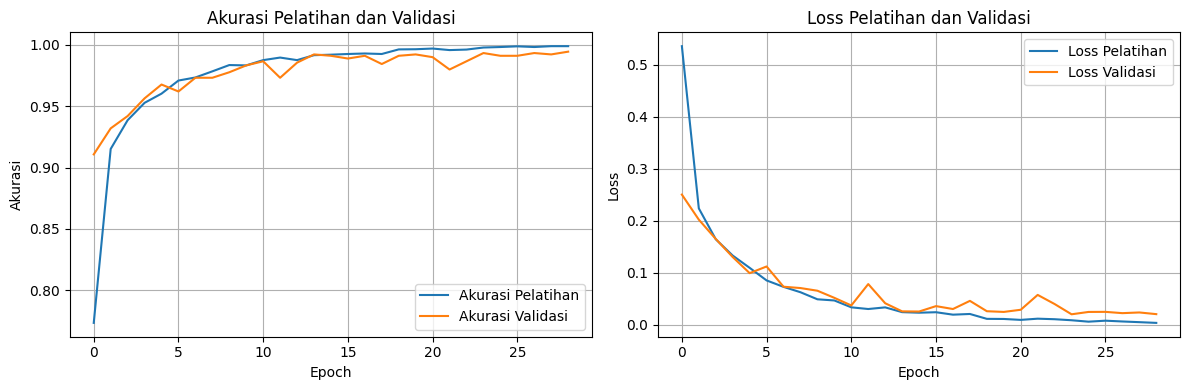

In [17]:
# Membuat plot dengan ukuran 12x4 inch
plt.figure(figsize=(12, 4))

# Tampilkan akurasi pelatihan dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.legend()
plt.grid()

# Tampilkan loss pelatihan dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.legend()
plt.grid()

# Mengatur layout plot agar tidak overlap
plt.tight_layout()

# Menampilkan plot
plt.show()

## Evaluasi dari Test Set

In [18]:
# Inisialisasi data untuk evaluasi
test_data_generator = data_generator(df_test, batch_size=cfg.BATCH_SIZE, augment=False, epochs=1)

# Inisialisasi prediksi dan label yang sesungguhnya
results = []  # Untuk menyimpan hasil evaluasi per sampel

# Inisialisasi nilai loss
loss = 0
count = 0

# Loop untuk mendapatkan prediksi dan label sesungguhnya
while True:
    try:
        x, y = next(test_data_generator)
        filenames = df_test.path[len(results):len(results) + len(y)]  # Ambil nama file batch

        # Prediksi probabilitas dan kelas
        preds = model.predict(x)
        pred_classes = np.argmax(preds, axis=-1)

        # Jika y adalah one-hot encoded
        if len(y.shape) > 1 and y.shape[-1] > 1:
            y = np.argmax(y, axis=-1)

        # Simpan hasil evaluasi
        for i, file_name in enumerate(filenames):
            result = {
                "filename": file_name,
                "true": int(y[i]),
                "predicted": int(pred_classes[i]),
                "probabilities": preds[i].tolist()
            }
            results.append(result)

        # Hitung nilai loss
        loss += model.evaluate(x, y, verbose=0)[0]
        count += 1
    except StopIteration:
        break

# Hitung nilai loss rata-rata
loss /= count
print(f'Test Loss: {loss:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

Classification Report:
              precision    recall  f1-score   support

     Healthy     1.0000    1.0000    1.0000       213
   Black Rot     0.9885    0.9961    0.9923       258
        ESCA     0.9957    0.9915    0.9936       236
 Leaf Blight     1.0000    0.9949    0.9975       197

    accuracy                         0.9956       904
   macro avg     0.9961    0.9956    0.9958       904
weighted avg     0.9956    0.9956    0.9956       904



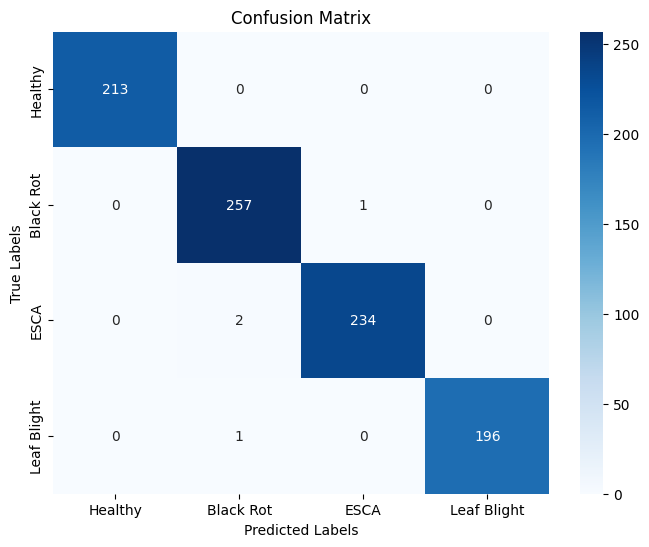

In [19]:
# Simpan hasil dalam CSV
df_results = pd.DataFrame(results)
df_results.to_csv("evaluation_results.csv", index=False)

# Tampilkan classification report
y_true = [r["true"] for r in results]
y_pred = [r["predicted"] for r in results]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=LABELS, digits=4))

# Visualisasi confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [21]:
# Direktori untuk menyimpan model hasil konversi
EXPORT_DIR = '/content/exported_models'
os.makedirs(EXPORT_DIR, exist_ok=True)

# Nama untuk setiap format model
SAVED_MODEL_DIR = os.path.join(EXPORT_DIR, 'saved_model')
TFLITE_DIR = os.path.join(EXPORT_DIR, 'tflite')
TFJS_DIR = os.path.join(EXPORT_DIR, 'tfjs_model')

os.makedirs(SAVED_MODEL_DIR, exist_ok=True)
os.makedirs(TFLITE_DIR, exist_ok=True)
os.makedirs(TFJS_DIR, exist_ok=True)

# Menyimpan dalam format SavedModel
model.export(SAVED_MODEL_DIR)
print(f"Model berhasil disimpan dalam format SavedModel di: {SAVED_MODEL_DIR}")

# Menyimpan dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_file = os.path.join(TFLITE_DIR, 'model.tflite')
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

# Menyimpan label untuk TF-Lite (opsional)
labels = np.array(LABELS)
labels_file = os.path.join(TFLITE_DIR, 'labels.txt')
np.savetxt(labels_file, labels, fmt='%s')

print(f"Model berhasil disimpan dalam format TF-Lite di: {tflite_file}")
if os.path.exists(labels_file):
    print(f"Label berhasil disimpan untuk TF-Lite di: {labels_file}")

# Menyimpan dalam format TFJS
!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, TFJS_DIR)
print(f"Model berhasil disimpan dalam format TFJS di: {TFJS_DIR}")

Saved artifact at '/content/exported_models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139252309633424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309634384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309637264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309636112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309636688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309638032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309634192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309638416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309637456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139252309638992: TensorSpec(shape=(), dtype=tf.resource, name=No

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TFJS di: /content/exported_models/tfjs_model


## Inference (Optional)

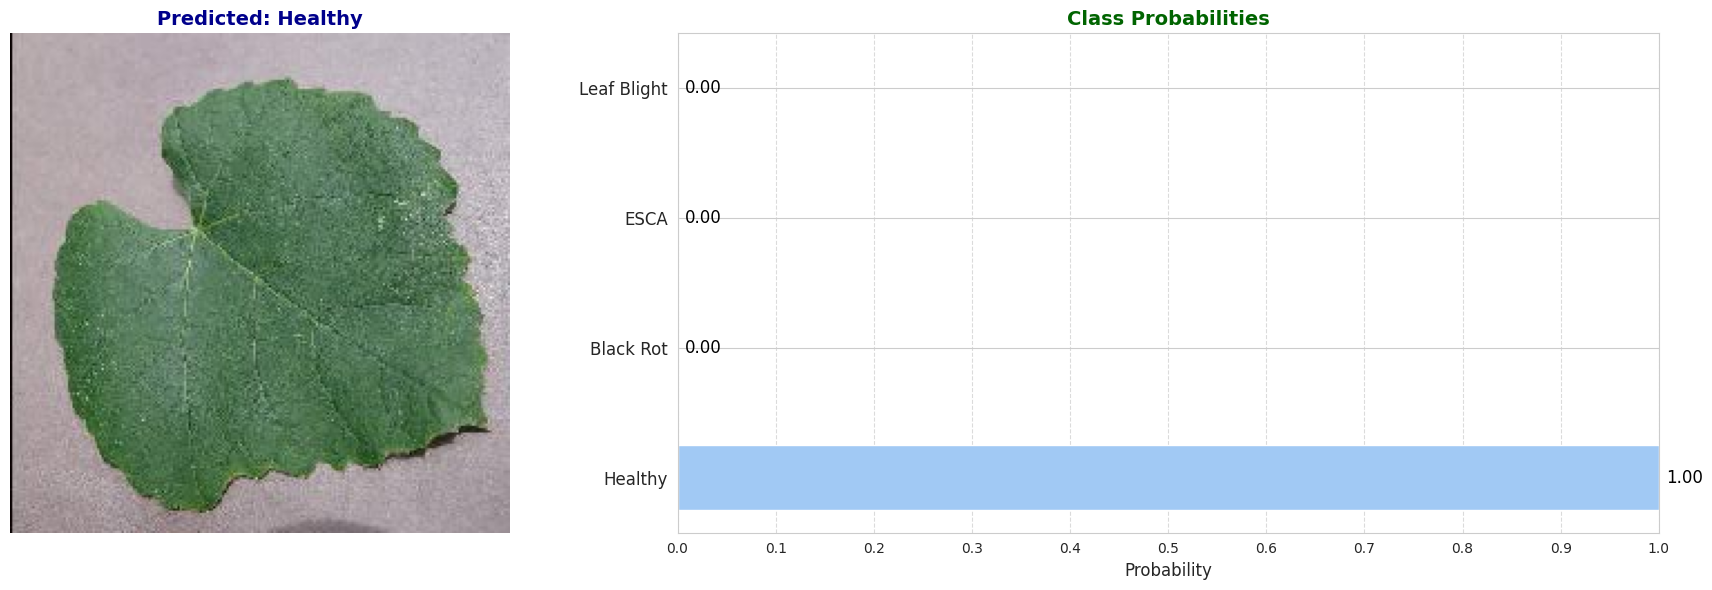

Actual Label    : Healthy
Predicted Label: Healthy
--------------------------------------------------------------------------------




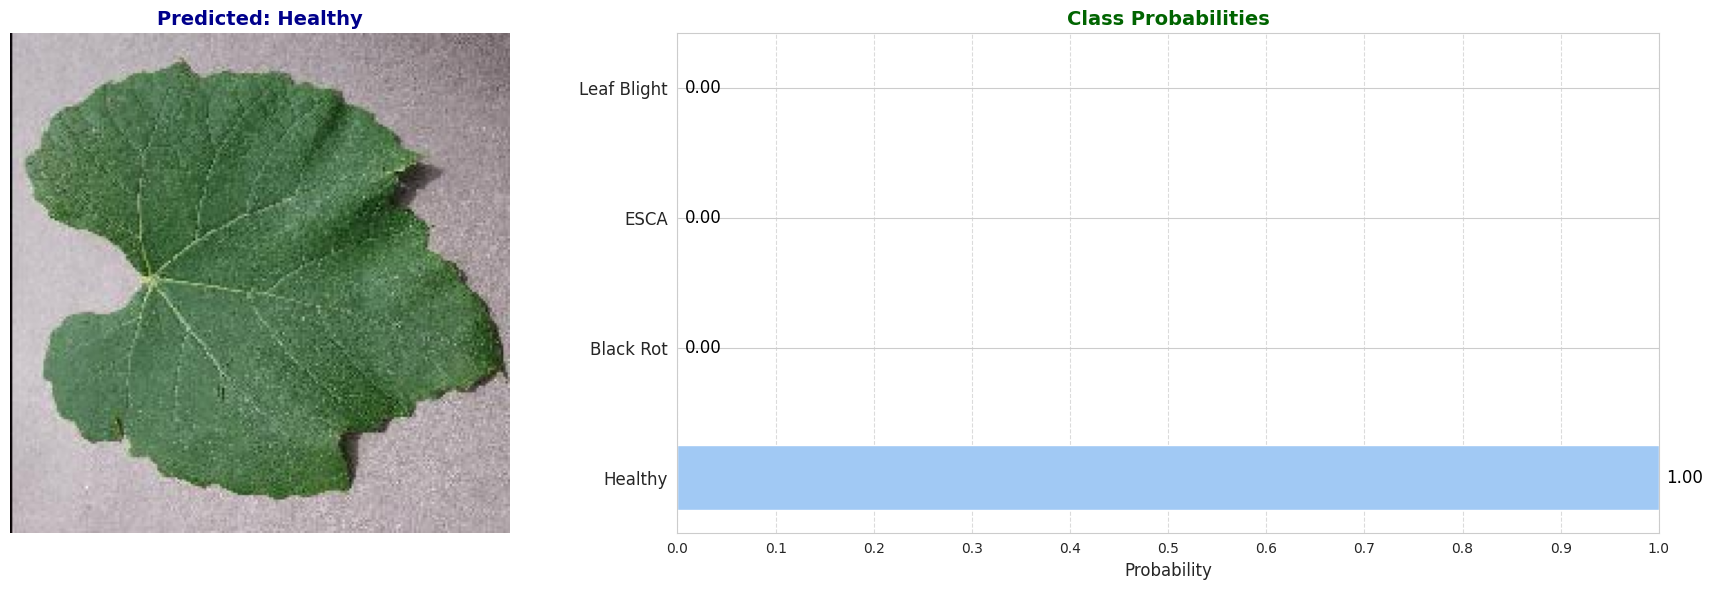

Actual Label    : Healthy
Predicted Label: Healthy
--------------------------------------------------------------------------------




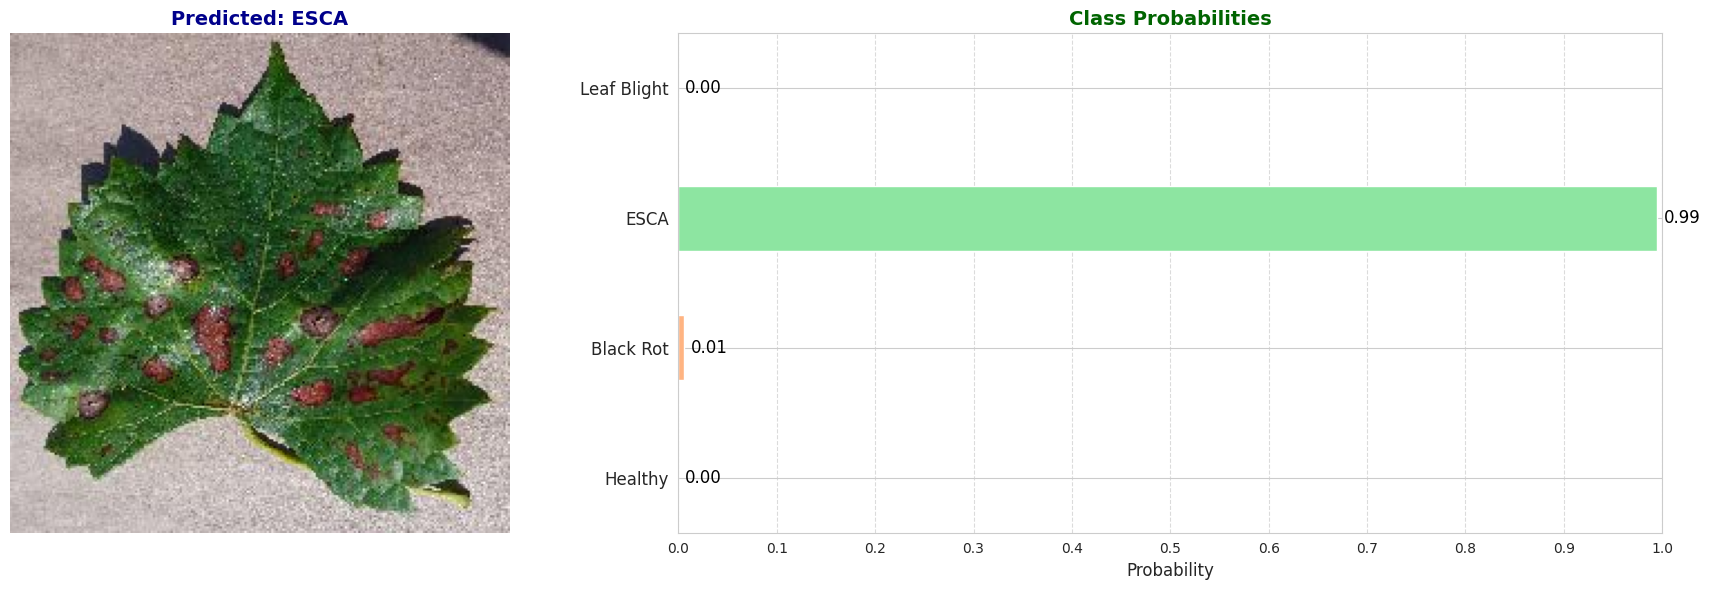

Actual Label    : ESCA
Predicted Label: ESCA
--------------------------------------------------------------------------------




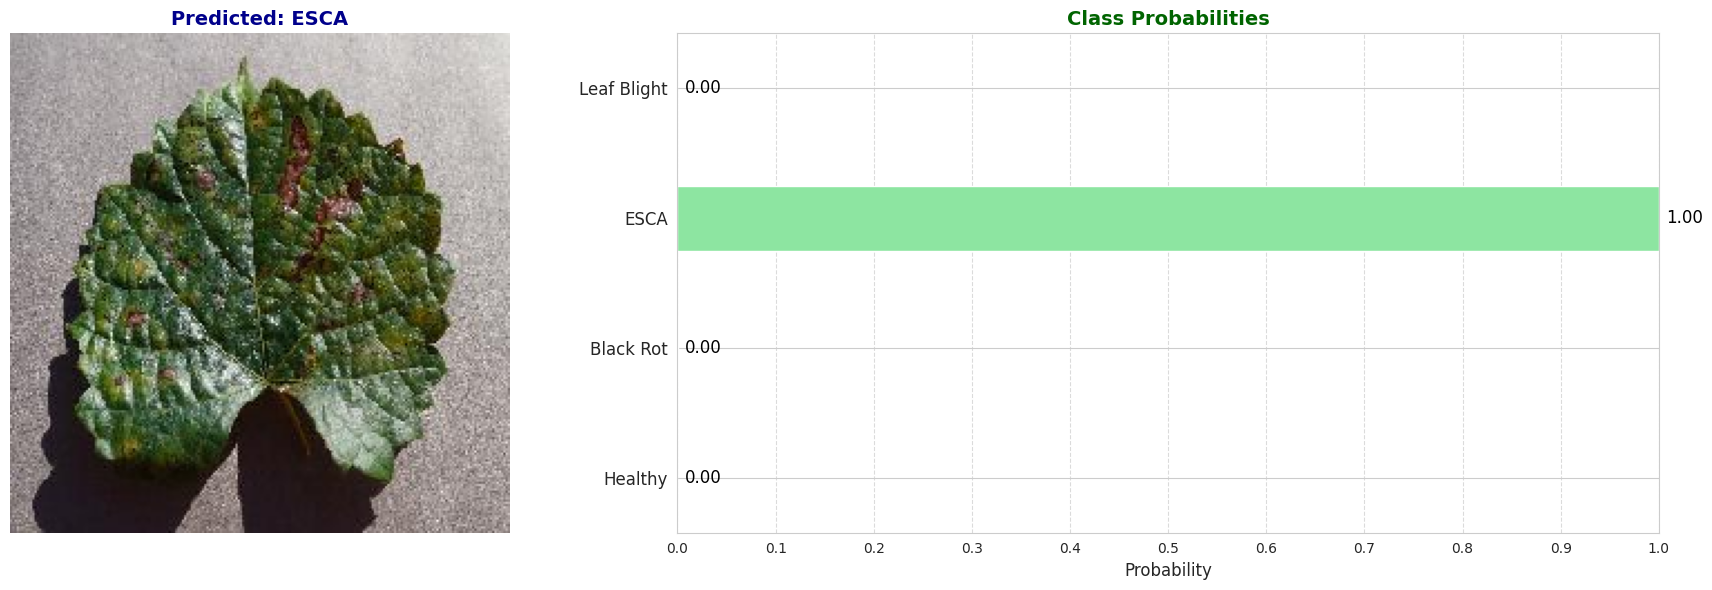

Actual Label    : ESCA
Predicted Label: ESCA
--------------------------------------------------------------------------------




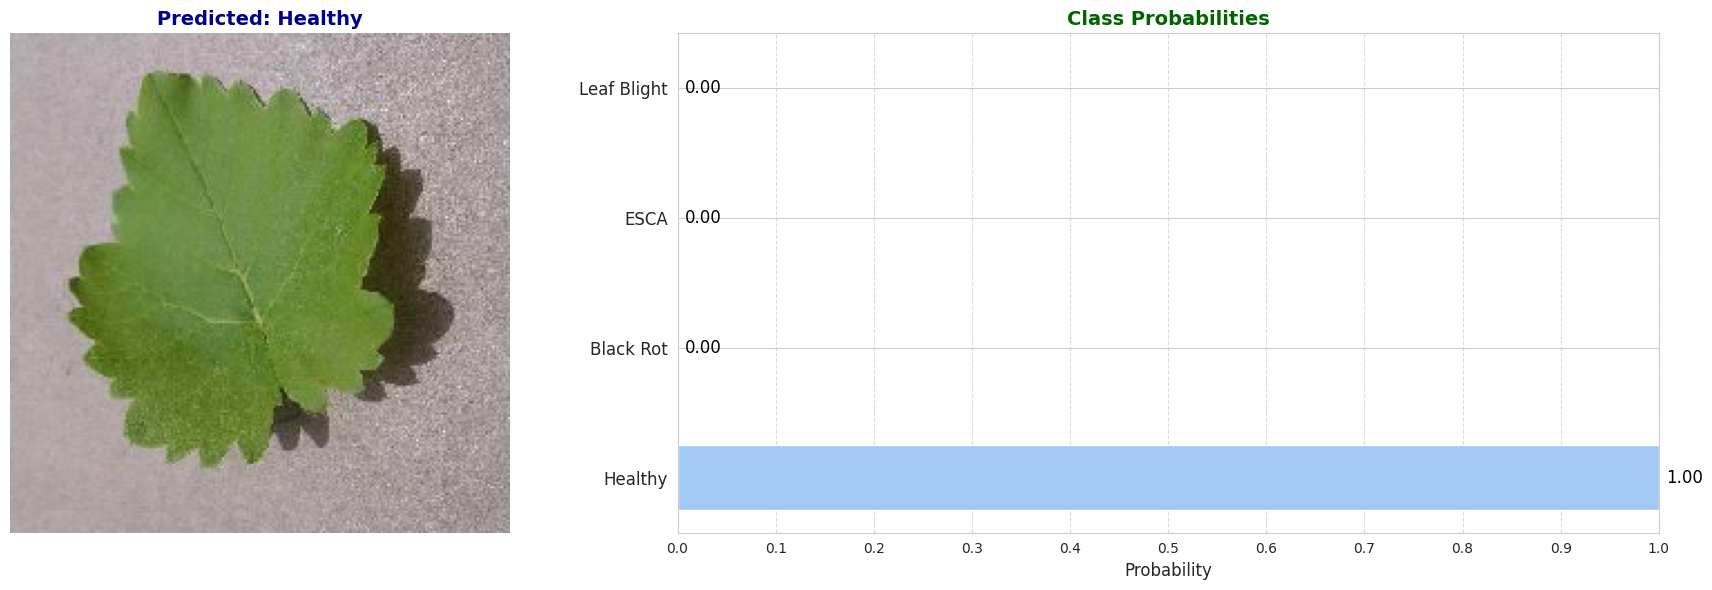

Actual Label    : Healthy
Predicted Label: Healthy
--------------------------------------------------------------------------------




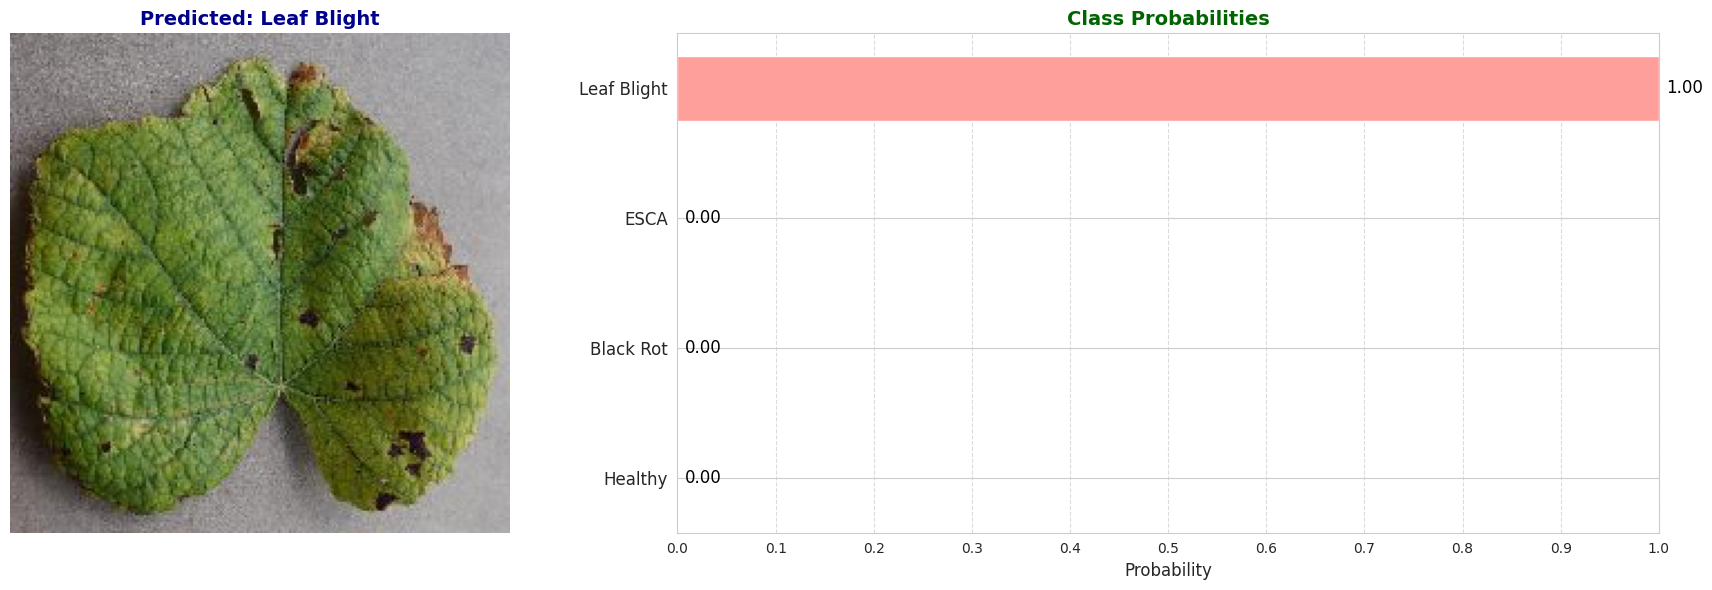

Actual Label    : Leaf Blight
Predicted Label: Leaf Blight
--------------------------------------------------------------------------------




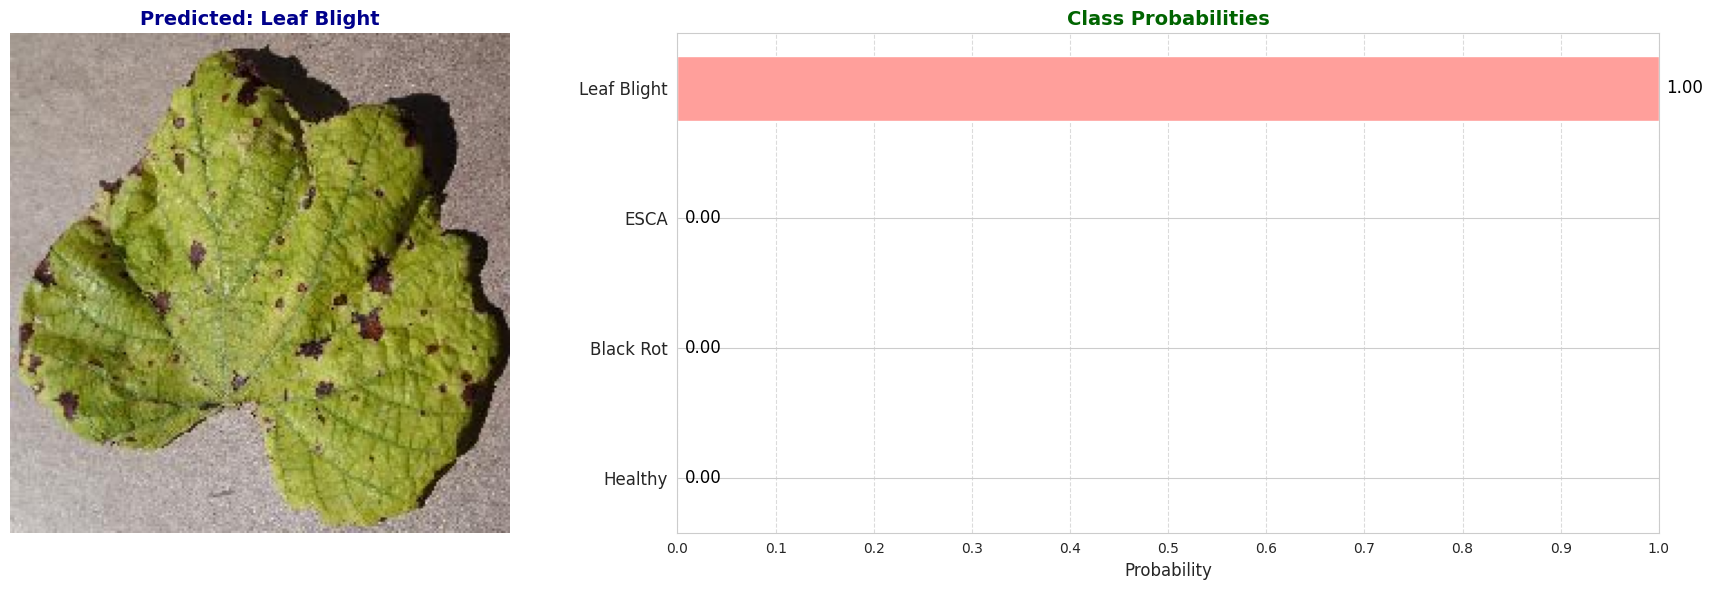

Actual Label    : Leaf Blight
Predicted Label: Leaf Blight
--------------------------------------------------------------------------------




In [22]:
def predict_from_tflite(image_path):
    labels = ['Healthy', 'Black Rot', 'ESCA', 'Leaf Blight']
    interpreter = tf.lite.Interpreter(model_path=os.path.join(TFLITE_DIR, 'model.tflite'))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    image = load_img(image_path, target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    image = np.array(image, dtype=np.float32)
    image = image / 255.0  # Normalisasi sesuai dengan bagaimana model dilatih
    image = np.expand_dims(image, axis=0)

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    probabilities = output_data[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_label = labels[predicted_class_index]
    probabilities_dict = {label: float(prob) for label, prob in zip(labels, probabilities)}

    return predicted_label, probabilities_dict

# Mengambil 7 indeks acak untuk pengujian
INDICES = random.sample(list(df_test.index), 7)

for INDEX in INDICES:
    image_path = df_test.path[INDEX]
    actual_label = df_test.label[INDEX]

    # Dapatkan prediksi dan probabilitas dari model TF-Lite
    pred, probabilities = predict_from_tflite(image_path)

    # Ambil label dan nilai probabilitas
    x = list(probabilities.keys())
    y = list(probabilities.values())

    # Set tampilan untuk visualisasi
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 3]})

    # Plot gambar
    image = load_img(image_path, target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    ax[0].imshow(image)
    ax[0].axis('off')  # Matikan sumbu pada gambar
    ax[0].set_title(f'Predicted: {pred}', fontsize=14, color='darkblue', weight='bold')

    # Membuat bar chart untuk probabilitas kelas
    bars = ax[1].barh(x, y, height=0.5, color=sns.color_palette("pastel", len(x)))
    ax[1].bar_label(bars, fmt='%.2f', padding=5, fontsize=12, label_type='edge', color='black')

    ax[1].set_xlim(0, 1)
    ax[1].set_xticks(np.arange(0, 1.1, 0.1))
    ax[1].set_xlabel('Probability', fontsize=12)
    ax[1].set_title('Class Probabilities', fontsize=14, color='darkgreen', weight='bold')
    ax[1].tick_params(axis='y', labelsize=12)
    ax[1].tick_params(axis='x', labelsize=10)
    ax[1].grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Tampilkan hasil pengujian
    print(f"Actual Label    : {actual_label}")
    print(f"Predicted Label: {pred}")
    print('-' * 80)
    print('\n')